In [3]:
# We use uv for faster installation
!pip install uv
!uv pip install -q autogluon.timeseries --system
!uv pip uninstall -q torchaudio torchvision torchtext --system # fix incompatible package versions on Colab


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import matplotlib.pyplot as plt

data = pd.read_csv('data/imputed_train.csv')
data['id'] = pd.to_datetime(data['id'])
data

c:\Users\User\anaconda3\envs\ag_2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,id,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25
0,2020-01-01 00:00:00,42.900000,0.718000,15.7,73.1,64.4
1,2020-01-01 01:00:00,33.600000,0.587000,10.1,74.8,66.0
2,2020-01-01 02:00:00,29.300000,0.400655,5.1,51.0,44.9
3,2020-01-01 03:00:00,30.500000,0.246000,7.2,27.7,25.1
4,2020-01-01 04:00:00,29.300000,0.204000,8.3,15.3,13.6
...,...,...,...,...,...,...
40986,2024-09-03 18:00:00,17.713860,0.222000,55.1,12.0,5.3
40987,2024-09-03 19:00:00,21.932757,0.245000,48.2,13.4,7.0
40988,2024-09-03 20:00:00,23.265996,0.234000,44.5,12.4,7.1
40989,2024-09-03 21:00:00,33.122175,0.225000,25.9,10.6,5.4


In [ ]:
data_long = pd.melt(data, id_vars=['id'], value_vars=['valeur_NO2', 'valeur_CO', 'valeur_O3', 'valeur_PM10', 'valeur_PM25'],
                    var_name='Pollutant', value_name='Value')
train_data = TimeSeriesDataFrame.from_data_frame(
    data_long,
    id_column="Pollutant",
    timestamp_column="id"
)
train_data.head()

Value
item_id    timestamp                 
valeur_NO2 2020-01-01 00:00:00   42.9
           2020-01-01 01:00:00   33.6
           2020-01-01 02:00:00   29.3
           2020-01-01 03:00:00   30.5
           2020-01-01 04:00:00   29.3

In [ ]:
predictor = TimeSeriesPredictor(
    prediction_length=504,
    path="autogluon-m4-hourly",
    target="Value",
    eval_metric="MAE",
)

predictor.fit(
    train_data,
    presets="medium_quality",
    time_limit=600,
)

NameError: name 'train_data' is not defined

In [ ]:
prediction = predictor.predict(train_data)[["mean"]]
prediction

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean
item_id     timestamp                     
valeur_NO2  2024-09-03 23:00:00  20.151454
            2024-09-04 00:00:00  19.795188
            2024-09-04 01:00:00  18.223992
            2024-09-04 02:00:00  17.992103
            2024-09-04 03:00:00  19.417732
...                                    ...
valeur_PM25 2024-09-24 18:00:00   8.706389
            2024-09-24 19:00:00   8.764595
            2024-09-24 20:00:00   9.172983
            2024-09-24 21:00:00   8.609866
            2024-09-24 22:00:00   7.961546

[2520 rows x 1 columns]

In [ ]:
prediction_wide = prediction.reset_index().pivot(index='timestamp', columns='item_id', values='mean')
prediction_wide["id"] = pd.to_datetime(prediction_wide.index)

ImportError: cannot import name 'clean_for_submission' from 'utils.preprocessing' (c:\Users\User\Mon Drive\DSB\2A HEC\Time series\time_series_project\utils\preprocessing.py)

In [ ]:
from utils.preprocessing import clean_for_submission

submission = pd.read_csv('submissions/matt_autogluon_raw.csv')
clean_for_submission(submission).to_csv('submissions/matt_autogluon_raw.csv', index=False)

# With all features on Colab

In [1]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

data_train = pd.read_csv("/content/drive/MyDrive/DSB/2A HEC/Time series/time_series_project/data/train_preprocessed.csv")

Mounted at /content/drive


In [16]:
data_train.isna().sum()

,0
id,0
valeur_NO2,3297
valeur_CO,12529
valeur_O3,693
valeur_PM10,7167
valeur_PM25,1791
is_holiday,0
is_jour_ferie,0
precipitation,0
wind_speed,0


In [4]:
data_train["id"] = pd.to_datetime(data_train["id"])
known_covariates = ['is_holiday', 'precipitation',
       'wind_speed', 'temperature', 'humidity', 'pressure', 'visibility',
       'global_solar_radiation', 'Year', 'is_weekend', 'DayOfYear',
       'HourOfDay', 'DayOfYear_sin', 'DayOfYear_cos', 'HourOfDay_sin',
       'HourOfDay_cos', 'Weekday_sin', 'Weekday_cos']
targets = ['valeur_NO2', 'valeur_CO', 'valeur_O3', 'valeur_PM10', 'valeur_PM25']
data = data_train[['id'] + targets + known_covariates]
data

,id,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25,is_holiday,precipitation,wind_speed,temperature,...,Year,is_weekend,DayOfYear,HourOfDay,DayOfYear_sin,DayOfYear_cos,HourOfDay_sin,HourOfDay_cos,Weekday_sin,Weekday_cos
0,2020-01-01 00:00:00,42.9,0.718,15.7,73.1,64.4,1,0.0,1.5,0.8,...,2020,0,1,0,0.017213,0.999852,0.000000,1.000000e+00,0.974928,-0.222521
1,2020-01-01 01:00:00,33.6,0.587,10.1,74.8,66.0,1,0.0,2.6,-0.7,...,2020,0,1,1,0.017213,0.999852,0.258819,9.659258e-01,0.974928,-0.222521
2,2020-01-01 02:00:00,29.3,NaN,5.1,51.0,44.9,1,0.0,1.9,-0.3,...,2020,0,1,2,0.017213,0.999852,0.500000,8.660254e-01,0.974928,-0.222521
3,2020-01-01 03:00:00,30.5,0.246,7.2,27.7,25.1,1,0.0,1.8,0.0,...,2020,0,1,3,0.017213,0.999852,0.707107,7.071068e-01,0.974928,-0.222521
4,2020-01-01 04:00:00,29.3,0.204,8.3,15.3,13.6,1,0.0,2.2,0.3,...,2020,0,1,4,0.017213,0.999852,0.866025,5.000000e-01,0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40986,2024-09-03 18:00:00,NaN,0.222,55.1,12.0,5.3,0,0.0,1.2,20.5,...,2024,0,247,18,-0.895839,-0.444378,-1.000000,-1.836970e-16,0.781831,0.623490
40987,2024-09-03 19:00:00,NaN,0.245,48.2,13.4,7.0,0,0.0,1.7,19.6,...,2024,0,247,19,-0.895839,-0.444378,-0.965926,2.588190e-01,0.781831,0.623490
40988,2024-09-03 20:00:00,NaN,0.234,44.5,12.4,7.1,0,0.0,2.0,18.4,...,2024,0,247,20,-0.895839,-0.444378,-0.866025,5.000000e-01,0.781831,0.623490
40989,2024-09-03 21:00:00,NaN,0.225,25.9,10.6,5.4,0,0.0,1.4,18.2,...,2024,0,247,21,-0.895839,-0.444378,-0.707107,7.071068e-01,0.781831,0.623490


In [5]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

train_data = pd.melt(data, id_vars=['id'] + known_covariates,
              value_vars=['valeur_NO2', 'valeur_CO', 'valeur_O3', 'valeur_PM10', 'valeur_PM25'],
              var_name='Pollutant', value_name='target')
train_data = TimeSeriesDataFrame.from_data_frame(
    train_data,
    id_column="Pollutant",
    timestamp_column="id",
)
train_data.head()

is_holiday  precipitation  wind_speed  \
item_id    timestamp                                                    
valeur_NO2 2020-01-01 00:00:00           1            0.0         1.5   
           2020-01-01 01:00:00           1            0.0         2.6   
           2020-01-01 02:00:00           1            0.0         1.9   
           2020-01-01 03:00:00           1            0.0         1.8   
           2020-01-01 04:00:00           1            0.0         2.2   

                                temperature  humidity  pressure  visibility  \
item_id    timestamp                                                          
valeur_NO2 2020-01-01 00:00:00          0.8      94.0    1022.5      2139.0   
           2020-01-01 01:00:00         -0.7      96.0    1022.2       509.0   
           2020-01-01 02:00:00         -0.3      98.0    1022.2       779.0   
           2020-01-01 03:00:00          0.0      98.0    1021.9       377.0   
           2020-01-01 04:00:00          0.3      98.0    1021.6      1317.0   

                                global_solar_radiation  Year  is_weekend  \
item_id    timestamp                                                       
valeur_NO2 2020-01-01 00:00:00                     0.0  2020           0   
           2020-01-01 01:00:00                     0.0  2020           0   
           2020-01-01 02:00:00                     0.0  2020           0   
           2020-01-01 03:00:00                     0.0  2020           0   
           2020-01-01 04:00:00                     0.0  2020           0   

                                DayOfYear  HourOfDay  DayOfYear_sin  \
item_id    timestamp                                                  
valeur_NO2 2020-01-01 00:00:00          1          0       0.017213   
           2020-01-01 01:00:00          1          1       0.017213   
           2020-01-01 02:00:00          1          2       0.017213   
           2020-01-01 03:00:00          1          3       0.017213   
           2020-01-01 04:00:00          1          4       0.017213   

                                DayOfYear_cos  HourOfDay_sin  HourOfDay_cos  \
item_id    timestamp                                                          
valeur_NO2 2020-01-01 00:00:00       0.999852       0.000000       1.000000   
           2020-01-01 01:00:00       0.999852       0.258819       0.965926   
           2020-01-01 02:00:00       0.999852       0.500000       0.866025   
           2020-01-01 03:00:00       0.999852       0.707107       0.707107   
           2020-01-01 04:00:00       0.999852       0.866025       0.500000   

                                Weekday_sin  Weekday_cos  target  
item_id    timestamp                                              
valeur_NO2 2020-01-01 00:00:00     0.974928    -0.222521    42.9  
           2020-01-01 01:00:00     0.974928    -0.222521    33.6  
           2020-01-01 02:00:00     0.974928    -0.222521    29.3  
           2020-01-01 03:00:00     0.974928    -0.222521    30.5  
           2020-01-01 04:00:00     0.974928    -0.222521    29.3

In [10]:
predictor = TimeSeriesPredictor(
    prediction_length=504,
    target="target",
    eval_metric="MAE",
    known_covariates_names=known_covariates
)

predictor.fit(
    train_data,
    presets="high_quality",
    time_limit=900,
)

Beginning AutoGluon training... Time limit = 900s
AutoGluon will save models to 'AutogluonModels/ag-20241030_110306'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          1
Memory Avail:       11.04 GB / 12.67 GB (87.1%)
Disk Space Avail:   74.48 GB / 112.64 GB (66.1%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAE,
 'hyperparameters': 'default',
 'known_covariates_names': ['is_holiday',
                            'precipitation',
                            'wind_speed',
                            'temperature',
                            'humidity',
                            'pressure',
                            'visibility',
                            'global_solar_radiation',
                           

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/806M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

	-5.7754       = Validation score (-MAE)
	0.28    s     = Training runtime
	92.60   s     = Validation (prediction) runtime
Training timeseries model TemporalFusionTransformer. Training for up to 76.7s of the 306.9s of remaining time.
	-7.7136       = Validation score (-MAE)
	76.01   s     = Training runtime
	0.68    s     = Validation (prediction) runtime
Training timeseries model DeepAR. Training for up to 76.7s of the 230.1s of remaining time.
	-11.0324      = Validation score (-MAE)
	72.90   s     = Training runtime
	3.14    s     = Validation (prediction) runtime
Training timeseries model PatchTST. Training for up to 77.0s of the 154.1s of remaining time.
	-5.7189       = Validation score (-MAE)
	70.06   s     = Training runtime
	0.18    s     = Validation (prediction) runtime
Fitting simple weighted ensemble.
	Ensemble weights: {'AutoARIMA': 0.29, 'Chronos[base]': 0.01, 'DirectTabular': 0.55, 'DynamicOptimizedTheta': 0.08, 'NPTS': 0.05, 'SeasonalNaive': 0.02}
	-4.9064       = Val

In [6]:
predictor = TimeSeriesPredictor.load("/content/drive/MyDrive/AutogluonModels/ag-20241030_110306")

In [7]:
test_data = pd.read_csv("/content/drive/MyDrive/DSB/2A HEC/Time series/time_series_project/data/test_preprocessed.csv")
test_data = pd.concat([test_data.assign(Pollutant=i) for i in targets], ignore_index=True)
test_data = TimeSeriesDataFrame.from_data_frame(
    test_data,
    id_column="Pollutant",
    timestamp_column="id",
)
predicted_values = predictor.predict(train_data, known_covariates=test_data)[["mean"]]

In [10]:
predicted_values_wide = predicted_values.reset_index().pivot(index='timestamp', columns='item_id', values='mean')
predicted_values_wide["id"] = pd.to_datetime(predicted_values_wide.index)
predicted_values_wide

item_id,valeur_CO,valeur_NO2,valeur_O3,valeur_PM10,valeur_PM25,id
timestamp,,,,,,
2024-09-03 23:00:00,0.207587,22.611733,43.204388,11.230150,6.888760,2024-09-03 23:00:00
2024-09-04 00:00:00,0.194376,19.800182,47.388620,11.549198,6.684520,2024-09-04 00:00:00
2024-09-04 01:00:00,0.200994,19.370732,41.538215,12.350877,7.659389,2024-09-04 01:00:00
2024-09-04 02:00:00,0.174875,18.436316,41.748238,11.330250,6.640536,2024-09-04 02:00:00
2024-09-04 03:00:00,0.164671,17.902708,38.267948,11.599253,6.381054,2024-09-04 03:00:00
...,...,...,...,...,...,...
2024-09-24 18:00:00,0.193421,17.876873,48.733787,13.560037,7.826760,2024-09-24 18:00:00
2024-09-24 19:00:00,0.217201,19.427222,49.487979,15.807538,9.189113,2024-09-24 19:00:00
2024-09-24 20:00:00,0.209292,18.986953,48.021268,15.090474,8.437398,2024-09-24 20:00:00


In [23]:
import sys
sys.path.append('/content/drive/MyDrive/DSB/2A HEC/Time series/time_series_project')
from utils.preprocessing import clean_for_submission

submission = clean_for_submission(predicted_values_wide)
submission.to_csv("/content/drive/MyDrive/DSB/2A HEC/Time series/time_series_project/submissions/matt_autogluon_features.csv", index=False)

In [26]:
predictor.feature_importance(train_data)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# With complete features

In [36]:
from utils.preprocessing import preprocess_data

data_train = pd.read_csv("/content/drive/MyDrive/DSB/2A HEC/Time series/time_series_project/data/train_preprocessed.csv")
data_train["id"] = pd.to_datetime(data_train["id"])
data_train.head()

,id,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25,is_holiday,is_jour_ferie,precipitation,wind_speed,...,is_weekend,DayOfYear,HourOfDay,Weekday,DayOfYear_sin,DayOfYear_cos,HourOfDay_sin,HourOfDay_cos,Weekday_sin,Weekday_cos
0,2020-01-01 00:00:00,42.9,0.718000,15.7,73.1,64.4,1,0,0.0,1.5,...,0,1,0,2,0.017213,0.999852,0.000000,1.000000,0.974928,-0.222521
1,2020-01-01 01:00:00,33.6,0.587000,10.1,74.8,66.0,1,0,0.0,2.6,...,0,1,1,2,0.017213,0.999852,0.258819,0.965926,0.974928,-0.222521
2,2020-01-01 02:00:00,29.3,0.400655,5.1,51.0,44.9,1,0,0.0,1.9,...,0,1,2,2,0.017213,0.999852,0.500000,0.866025,0.974928,-0.222521
3,2020-01-01 03:00:00,30.5,0.246000,7.2,27.7,25.1,1,0,0.0,1.8,...,0,1,3,2,0.017213,0.999852,0.707107,0.707107,0.974928,-0.222521
4,2020-01-01 04:00:00,29.3,0.204000,8.3,15.3,13.6,1,0,0.0,2.2,...,0,1,4,2,0.017213,0.999852,0.866025,0.500000,0.974928,-0.222521


In [37]:
data_train.isna().sum()

,0
id,0
valeur_NO2,0
valeur_CO,0
valeur_O3,0
valeur_PM10,0
valeur_PM25,0
is_holiday,0
is_jour_ferie,0
precipitation,0
wind_speed,0


In [38]:
known_covariates = ['is_holiday', 'precipitation',
       'wind_speed', 'temperature', 'humidity', 'pressure', 'visibility',
       'global_solar_radiation', 'Year', 'is_weekend', 'DayOfYear',
       'HourOfDay', 'DayOfYear_sin', 'DayOfYear_cos', 'HourOfDay_sin',
       'HourOfDay_cos', 'Weekday_sin', 'Weekday_cos', "car_flow"]
targets = ['valeur_NO2', 'valeur_CO', 'valeur_O3', 'valeur_PM10', 'valeur_PM25']
data = data_train[['id'] + targets + known_covariates]

In [39]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

train_data = pd.melt(data, id_vars=['id'] + known_covariates,
              value_vars=['valeur_NO2', 'valeur_CO', 'valeur_O3', 'valeur_PM10', 'valeur_PM25'],
              var_name='Pollutant', value_name='target')
train_data = TimeSeriesDataFrame.from_data_frame(
    train_data,
    id_column="Pollutant",
    timestamp_column="id",
)
train_data.head()

is_holiday  precipitation  wind_speed  \
item_id    timestamp                                                    
valeur_NO2 2020-01-01 00:00:00           1            0.0         1.5   
           2020-01-01 01:00:00           1            0.0         2.6   
           2020-01-01 02:00:00           1            0.0         1.9   
           2020-01-01 03:00:00           1            0.0         1.8   
           2020-01-01 04:00:00           1            0.0         2.2   

                                temperature  humidity  pressure  visibility  \
item_id    timestamp                                                          
valeur_NO2 2020-01-01 00:00:00          0.8      94.0    1022.5      2139.0   
           2020-01-01 01:00:00         -0.7      96.0    1022.2       509.0   
           2020-01-01 02:00:00         -0.3      98.0    1022.2       779.0   
           2020-01-01 03:00:00          0.0      98.0    1021.9       377.0   
           2020-01-01 04:00:00          0.3      98.0    1021.6      1317.0   

                                global_solar_radiation  Year  is_weekend  \
item_id    timestamp                                                       
valeur_NO2 2020-01-01 00:00:00                     0.0  2020           0   
           2020-01-01 01:00:00                     0.0  2020           0   
           2020-01-01 02:00:00                     0.0  2020           0   
           2020-01-01 03:00:00                     0.0  2020           0   
           2020-01-01 04:00:00                     0.0  2020           0   

                                DayOfYear  HourOfDay  DayOfYear_sin  \
item_id    timestamp                                                  
valeur_NO2 2020-01-01 00:00:00          1          0       0.017213   
           2020-01-01 01:00:00          1          1       0.017213   
           2020-01-01 02:00:00          1          2       0.017213   
           2020-01-01 03:00:00          1          3       0.017213   
           2020-01-01 04:00:00          1          4       0.017213   

                                DayOfYear_cos  HourOfDay_sin  HourOfDay_cos  \
item_id    timestamp                                                          
valeur_NO2 2020-01-01 00:00:00       0.999852       0.000000       1.000000   
           2020-01-01 01:00:00       0.999852       0.258819       0.965926   
           2020-01-01 02:00:00       0.999852       0.500000       0.866025   
           2020-01-01 03:00:00       0.999852       0.707107       0.707107   
           2020-01-01 04:00:00       0.999852       0.866025       0.500000   

                                Weekday_sin  Weekday_cos    car_flow  target  
item_id    timestamp                                                          
valeur_NO2 2020-01-01 00:00:00     0.974928    -0.222521         NaN    42.9  
           2020-01-01 01:00:00     0.974928    -0.222521  665.634534    33.6  
           2020-01-01 02:00:00     0.974928    -0.222521  812.483517    29.3  
           2020-01-01 03:00:00     0.974928    -0.222521  825.396832    30.5  
           2020-01-01 04:00:00     0.974928    -0.222521  748.093018    29.3

In [43]:
predictor = TimeSeriesPredictor(
    prediction_length=504,
    target="target",
    eval_metric="MAE",
    known_covariates_names=known_covariates,
    path="/content/drive/MyDrive/AutogluonModels/full_imputed",
    freq="H"
)

predictor.fit(
    train_data,
    presets="best_quality",
    time_limit=1200,
    excluded_model_types=["AutoARIMA"]
)

/usr/local/lib/python3.10/dist-packages/autogluon/timeseries/predictor.py:199: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  std_freq = pd.tseries.frequencies.to_offset(self.freq).freqstr
Frequency 'H' stored as 'h'
Beginning AutoGluon training... Time limit = 1200s
AutoGluon will save models to '/content/drive/MyDrive/AutogluonModels/full_imputed'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          1
Memory Avail:       8.98 GB / 12.67 GB (70.9%)
Disk Space Avail:   5.84 GB / 100.00 GB (5.8%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAE,
 'freq': 'h',
 'hyperparamete

In [45]:
predictor.leaderboard(train_data)

data with frequency 'None' has been resampled to frequency 'h'.
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,Chronos[base],-5.292261,-6.192553,42.967878,43.082131,43.199066,8
1,PatchTST,-5.343801,-6.131482,0.278148,0.242173,96.974015,11
2,NPTS,-5.413503,-5.587758,43.654866,43.653755,43.666577,5
3,DynamicOptimizedTheta,-6.012367,-7.853131,2.819746,2.700788,2.770841,6
4,SeasonalNaive,-6.322578,-7.937554,0.086481,0.071630,0.700457,1
5,CrostonSBA,-6.632140,-7.867789,0.102568,0.076878,2.545316,4
6,AutoETS,-6.636452,-28.141875,21.956956,22.897453,41.413478,7
7,DeepAR,-7.921247,-7.042217,2.808344,2.892550,100.540615,10
8,TemporalFusionTransformer,-9.062319,-8.121508,1.103501,0.394423,98.724718,9
9,RecursiveTabular,-12.388382,-11.140473,18.113650,17.726464,97.843390,2


In [62]:
test_data = pd.read_csv("/content/drive/MyDrive/DSB/2A HEC/Time series/time_series_project/data/test_preprocessed.csv")
test_data = pd.concat([test_data.assign(Pollutant=i) for i in targets], ignore_index=False)
test_data.sort_index(ascending=True, inplace=True)
test_data

,id,is_holiday,is_jour_ferie,precipitation,wind_speed,temperature,humidity,pressure,visibility,global_solar_radiation,...,DayOfYear,HourOfDay,Weekday,DayOfYear_sin,DayOfYear_cos,HourOfDay_sin,HourOfDay_cos,Weekday_sin,Weekday_cos,Pollutant
0,2024-09-03 23:00:00,0,0,0.0,1.4,18.6,82.0,1007.6,20000.0,0.0,...,247,23,1,-0.895839,-0.444378,-0.258819,0.965926,0.781831,0.62349,valeur_NO2
0,2024-09-03 23:00:00,0,0,0.0,1.4,18.6,82.0,1007.6,20000.0,0.0,...,247,23,1,-0.895839,-0.444378,-0.258819,0.965926,0.781831,0.62349,valeur_CO
0,2024-09-03 23:00:00,0,0,0.0,1.4,18.6,82.0,1007.6,20000.0,0.0,...,247,23,1,-0.895839,-0.444378,-0.258819,0.965926,0.781831,0.62349,valeur_PM25
0,2024-09-03 23:00:00,0,0,0.0,1.4,18.6,82.0,1007.6,20000.0,0.0,...,247,23,1,-0.895839,-0.444378,-0.258819,0.965926,0.781831,0.62349,valeur_PM10
0,2024-09-03 23:00:00,0,0,0.0,1.4,18.6,82.0,1007.6,20000.0,0.0,...,247,23,1,-0.895839,-0.444378,-0.258819,0.965926,0.781831,0.62349,valeur_O3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,2024-09-24 22:00:00,0,0,0.0,2.4,14.1,93.0,999.9,13548.0,0.0,...,268,22,1,-0.995105,-0.098820,-0.500000,0.866025,0.781831,0.62349,valeur_PM10
503,2024-09-24 22:00:00,0,0,0.0,2.4,14.1,93.0,999.9,13548.0,0.0,...,268,22,1,-0.995105,-0.098820,-0.500000,0.866025,0.781831,0.62349,valeur_CO
503,2024-09-24 22:00:00,0,0,0.0,2.4,14.1,93.0,999.9,13548.0,0.0,...,268,22,1,-0.995105,-0.098820,-0.500000,0.866025,0.781831,0.62349,valeur_NO2
503,2024-09-24 22:00:00,0,0,0.0,2.4,14.1,93.0,999.9,13548.0,0.0,...,268,22,1,-0.995105,-0.098820,-0.500000,0.866025,0.781831,0.62349,valeur_O3


In [64]:
test_data = TimeSeriesDataFrame.from_data_frame(
    test_data,
    id_column="Pollutant",
    timestamp_column="id",
)
predicted_values = predictor.predict(train_data, known_covariates=test_data)[["mean"]]

data with frequency 'None' has been resampled to frequency 'h'.
Trying to fill missing values in an unsorted dataframe. It is highly recommended to call `ts_df.sort_index()` before calling `ts_df.fill_missing_values()`
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [65]:
predicted_values_wide = predicted_values.reset_index().pivot(index='timestamp', columns='item_id', values='mean')
predicted_values_wide["id"] = pd.to_datetime(predicted_values_wide.index)
predicted_values_wide

item_id,valeur_CO,valeur_NO2,valeur_O3,valeur_PM10,valeur_PM25,id
timestamp,,,,,,
2024-09-03 23:00:00,0.185280,15.424996,44.110031,14.321313,6.098235,2024-09-03 23:00:00
2024-09-04 00:00:00,0.173351,13.838302,47.736602,12.631835,5.940834,2024-09-04 00:00:00
2024-09-04 01:00:00,0.167237,14.014590,45.315677,12.692910,7.403427,2024-09-04 01:00:00
2024-09-04 02:00:00,0.145469,12.203080,45.118934,11.466885,5.581341,2024-09-04 02:00:00
2024-09-04 03:00:00,0.139192,13.316889,43.570834,11.055631,6.086031,2024-09-04 03:00:00
...,...,...,...,...,...,...
2024-09-24 18:00:00,0.160937,11.537405,49.423954,14.811725,7.409720,2024-09-24 18:00:00
2024-09-24 19:00:00,0.189637,17.013028,51.574781,16.672992,9.325064,2024-09-24 19:00:00
2024-09-24 20:00:00,0.174847,16.854241,47.241816,16.084922,8.616065,2024-09-24 20:00:00


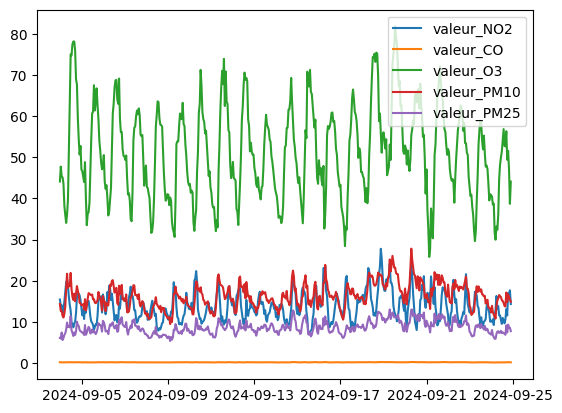

In [66]:
import matplotlib.pyplot as plt
for target in targets:
  plt.plot(predicted_values_wide[target], label=target)
plt.legend()
plt.show()

In [67]:
submission = clean_for_submission(predicted_values_wide)
submission.to_csv("/content/drive/MyDrive/DSB/2A HEC/Time series/time_series_project/submissions/matt_autogluon_features_2.csv", index=False)